In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mplsoccer import Sbopen, Pitch

parser = Sbopen()
pitch = Pitch(line_zorder=2)

bins = (pitch.dim.positional_x[[0,3,4,5,6]], pitch.dim.positional_y)

dataframe_match = parser.match(competition_id=11, season_id=24)
match_ids = dataframe_match.match_id.unique()

all_events_dataframe = []
set_pieces = ['Thrown-in', 'Free Kick', 'Goal Kick', 'Corner', 'Kick Off', 'Penalty']
cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name', 
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']

for match_id in match_ids:
    event = parser.event(match_id)[0]
    event = event.loc[(event.type_name.isin(['Carry', 'Shot', 'Pass']) & 
                       (~event.type_name.isin(set_pieces))), cols].copy()
    
    
    event['goal'] = event['outcome_name'] == 'Goal'
    event['shoot'] = event['type_name'] == 'Shot'
    event['move'] = event['type_name'] != 'Shot'
    all_events_dataframe.append(event)

event = pd.concat(all_events_dataframe)

shot_prob = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)
move_prob = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)
goal_prob = pitch.bin_statistic(event.loc[event['shoot'], 'x'],
                                       event.loc[event['shoot'], 'y'],
                                       event.loc[event['shoot'], 'shot_statsbomb_xg'],
                                       statistic='mean', bins=bins)


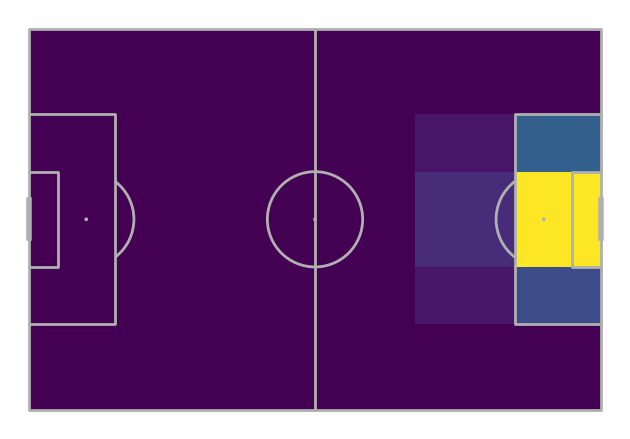

In [3]:
fig, ax = pitch.draw()
shot_heatmap = pitch.heatmap(shot_prob, ax=ax)

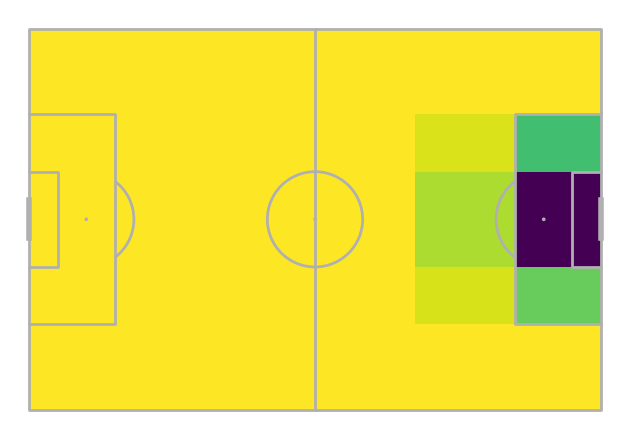

In [4]:
fig, ax = pitch.draw()
move_heatmap = pitch.heatmap(move_prob, ax=ax)

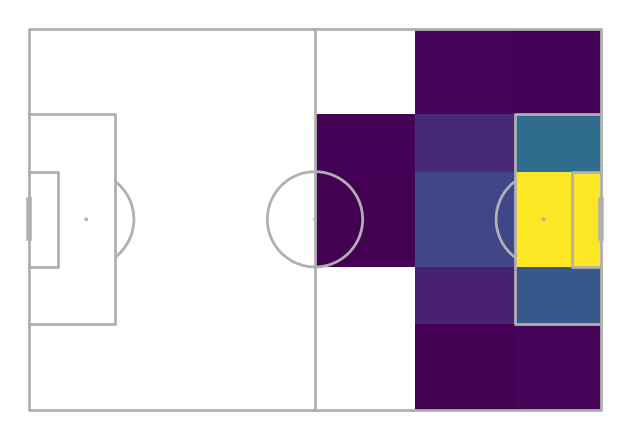

In [5]:
fig, ax = pitch.draw()
goal_heatmap = pitch.heatmap(goal_prob, ax=ax)

In [6]:
move = event[event['move']].copy()
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
move = move[bin_start_locations['inside']].copy()

bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)
move_success = move[(bin_end_locations['inside'])&(move['outcome_name'].isnull())].copy()

bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)
dataframe_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                              'y': bin_success_start['binnumber'][1],
                              'end_x' : bin_success_end['binnumber'][0],
                              'end_y' : bin_success_end['binnumber'][1]})

bin_counts = dataframe_bin.value_counts().reset_index(name='bin_counts')

num_y, num_x = shot_prob['statistic'].shape
move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins = bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2,3))
move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations!=0,
                                   )
move_transition_matrix = np.nan_to_num(move_transition_matrix)
shot_prob_matrix = np.nan_to_num(shot_prob['statistic'])
move_prob_matrix = np.nan_to_num(move_prob['statistic'])
goal_prob_matrix = np.nan_to_num(goal_prob['statistic'])

In [7]:
expected_threat = np.multiply(shot_prob_matrix, goal_prob_matrix)
diff = 1
iteration = 0

while np.any(diff>0.00001):
    xt_copy = expected_threat.copy()
    
    expected_threat = (np.multiply(shot_prob_matrix, goal_prob_matrix)+
                       np.multiply(move_prob_matrix, 
                                   np.multiply(move_transition_matrix, np.expand_dims(expected_threat, axis=(0,1))).sum(
                                       axis=(2,3)))
                       )
    diff = (expected_threat-xt_copy)
    iteration +=1
print("Number of iterations:", iteration)

Number of iterations: 49


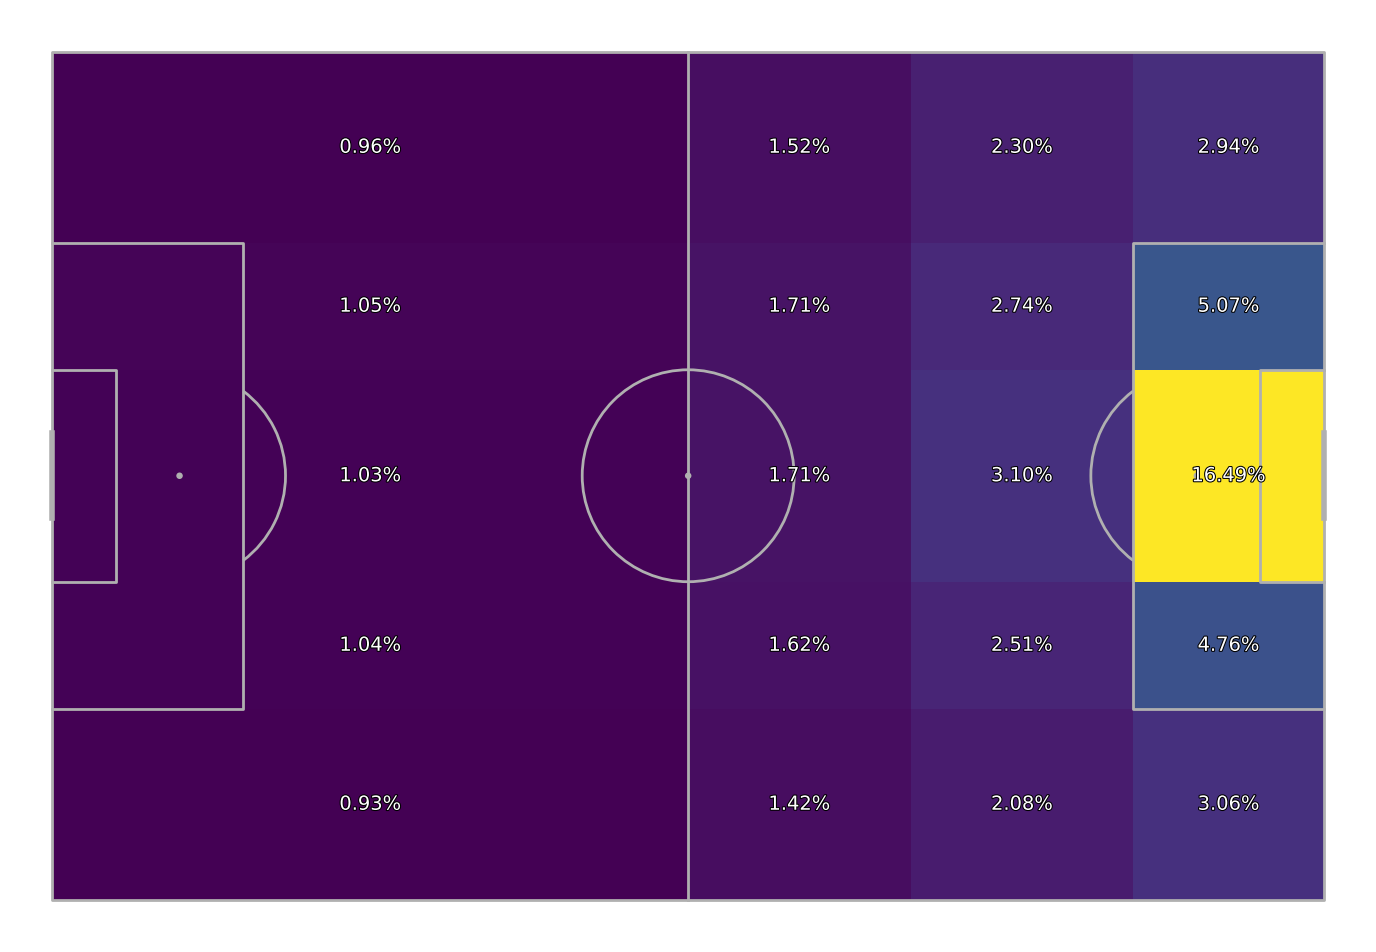

In [8]:
path_eff = [path_effects.Stroke(linewidth = 1.5, foreground = 'black'),
            path_effects.Normal()]

for_plotting = pitch.bin_statistic(event['x'], event['y'], bins=bins)
for_plotting['statistic'] = expected_threat
fig, ax = pitch.draw(figsize=(14,9.625))
_ = pitch.heatmap(for_plotting, ax=ax)
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize = 14, va = 'center', ha = 'center',
                        path_effects=path_eff)

In [9]:
grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins = bins)
grid_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins = bins)

start_xt = expected_threat[grid_start['binnumber'][1], grid_start['binnumber'][0]]
end_xt = expected_threat[grid_end['binnumber'][1], grid_end['binnumber'][0]]

added_xt = end_xt-start_xt
move_success['xt'] = added_xt

move_success.groupby('player_name')['xt'].sum().sort_values(ascending=False).head(5)

player_name
Lionel Andrés Messi Cuccittini    11.340587
Andrés Iniesta Luján               6.874743
Daniel Alves da Silva              6.534045
Xavier Hernández Creus             6.029978
Francesc Fàbregas i Soler          5.321912
Name: xt, dtype: float64